In [2]:
pip install opencv-python mediapipe pyc3dserver matplotlib


INFO: pip is looking at multiple versions of pyc3dserver to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 47.2 MB/s eta 0:00:00


In [3]:
!pip install ezc3d


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.4 MB/s eta 0:00:00


In [4]:
import cv2
import mediapipe as mp
import numpy as np
import ezc3d

# Step 1: Extract 2D/3D keypoints from the video
def extract_keypoints(video_path):
    mp_pose = mp.solutions.pose
    keypoints_list = []  # Store keypoints for all frames
    cap = cv2.VideoCapture(video_path)

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)

            if results.pose_landmarks:
                keypoints = [
                    (lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark
                ]
                keypoints_list.append(keypoints)
            else:
                keypoints_list.append(None)  # Append None if no keypoints detected

    cap.release()
    return keypoints_list

# Step 2: Convert keypoints into C3D format
def create_c3d_file(keypoints_list, output_file, frame_rate=30):
    c3d = ezc3d.c3d()
    num_frames = len(keypoints_list)
    num_markers = len(keypoints_list[0]) if keypoints_list[0] else 0

    # Add labels for markers
    marker_labels = [f"Marker_{i+1}" for i in range(num_markers)]
    c3d["parameters"]["POINT"]["LABELS"]["value"] = marker_labels

    # Add empty data for the required number of frames and markers
    c3d['data']['points'] = np.zeros((4, num_markers, num_frames))

    for frame_idx, frame_keypoints in enumerate(keypoints_list):
        if frame_keypoints:
            for marker_idx, (x, y, z) in enumerate(frame_keypoints):
                c3d['data']['points'][:3, marker_idx, frame_idx] = [x, y, z]  # X, Y, Z
                c3d['data']['points'][3, marker_idx, frame_idx] = 1  # Valid marker
        else:
            # Set all markers to invalid for missing frames
            c3d['data']['points'][3, :, frame_idx] = 0  # Invalid marker

    # Set frame rate and write to file
    c3d['parameters']['POINT']['RATE']['value'] = [frame_rate]
    c3d.write(output_file)
    print(f"C3D file created: {output_file}")


# Step 3: Visualize C3D file in Python
def visualize_c3d(c3d_file):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    c3d = ezc3d.c3d(c3d_file)
    points = c3d['data']['points']
    num_frames = points.shape[2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for frame_idx in range(num_frames):
        ax.clear()
        for marker_idx in range(points.shape[1]):
            if points[3, marker_idx, frame_idx] == 1:  # Valid marker
                ax.scatter(
                    points[0, marker_idx, frame_idx],
                    points[1, marker_idx, frame_idx],
                    points[2, marker_idx, frame_idx],
                    c="blue", s=20
                )
        plt.pause(0.01)

    plt.show()




C3D file created: output.c3d


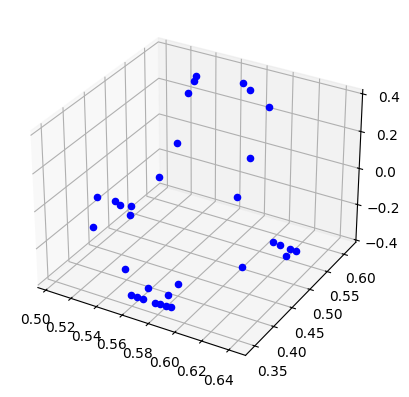

In [10]:
# Example usage
video_path = "/content/VID-20250109-WA0004.mp4"  # Replace with your video path
c3d_output_path = "output.c3d"

# Step 1: Extract keypoints from video
keypoints = extract_keypoints(video_path)

# Step 2: Create C3D file
create_c3d_file(keypoints, c3d_output_path, frame_rate=30)

# Step 3: Visualize in Python (optional)
visualize_c3d(c3d_output_path)

In [23]:
def visualize_c3d_2d(c3d_file):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    c3d = ezc3d.c3d(c3d_file)
    points = c3d['data']['points']
    num_frames = points.shape[2]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_facecolor("black")
    ax.set_xlim(-0.4, 0.4)  # Adjust based on your data range
    ax.set_ylim(-0.4, 0.4)
    #ax.grid(color="white", linestyle="--", linewidth=0.5)
    ax.set_xticks(np.linspace(-1, 1, 11))
    ax.set_yticks(np.linspace(-1, 1, 11))

    for frame_idx in range(num_frames):
        ax.clear()
        ax.set_facecolor("black")
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        #ax.grid(color="white", linestyle="--", linewidth=0.5)
        ax.set_xticks(np.linspace(-1, 1, 11))
        ax.set_yticks(np.linspace(-1, 1, 11))

        for marker_idx in range(points.shape[1]):
            if points[3, marker_idx, frame_idx] == 1:  # Valid marker
                ax.scatter(
                    points[0, marker_idx, frame_idx],  # X-axis
                    points[1, marker_idx, frame_idx],  # Y-axis
                    c="white", s=20
                )

        plt.pause(0.01)

    plt.show()


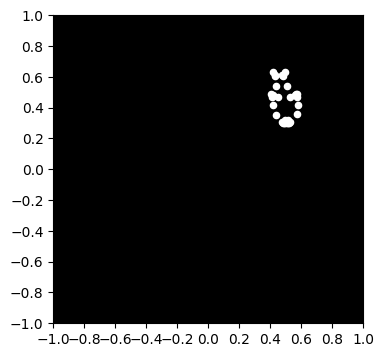

In [24]:
visualize_c3d_2d(c3d_output_path)

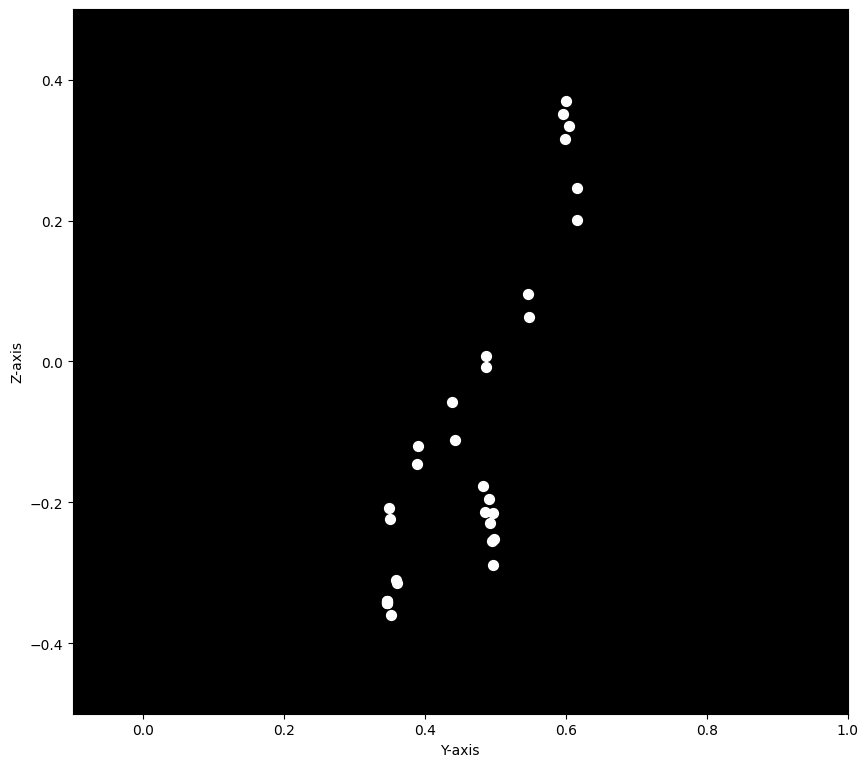

In [15]:
def visualize_c3d_2d_projection(c3d_file, plane="XZ"):
    import matplotlib.pyplot as plt
    import numpy as np

    c3d = ezc3d.c3d(c3d_file)  # Load the C3D file
    points = c3d['data']['points']  # Extract marker points (4 x markers x frames)
    num_frames = points.shape[2]  # Total number of frames

    # Set up figure for 2D visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("black")  # Set background color to black

    # Set axes labels and limits based on the selected plane
    if plane == "XY":
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_xlim(0.3, 0.7)  # Adjust based on X range
        ax.set_ylim(-0.5, 0.5)  # Adjust based on Y range
    elif plane == "XZ":
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Z-axis")
        ax.set_xlim(0.3, 0.7)  # Adjust based on X range
        ax.set_ylim(-0.5, 0.5)  # Adjust based on Z range
    elif plane == "YZ":
        ax.set_xlabel("Y-axis")
        ax.set_ylabel("Z-axis")
        ax.set_xlim(-0.5, 0.5)  # Adjust based on Y range
        ax.set_ylim(-0.5, 0.5)  # Adjust based on Z range
    else:
        raise ValueError("Invalid plane selected. Choose 'XY', 'XZ', or 'YZ'.")

    ax.set_aspect("equal", adjustable="box")  # Maintain equal scaling for axes
    ax.grid(color="white", linestyle="--", linewidth=0.5)  # Add grid lines for reference

    for frame_idx in range(num_frames):  # Loop through each frame
        ax.clear()  # Clear previous frame for animation
        ax.set_facecolor("black")  # Reset background color

        # Reset axes labels and limits for each frame
        if plane == "XY":
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Y-axis")
            ax.set_xlim(0.3, 0.7)
            ax.set_ylim(-0.1, 1)
        elif plane == "XZ":
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Z-axis")
            ax.set_xlim(0.3, 0.7)
            ax.set_ylim(-0.5, 0.5)
        elif plane == "YZ":
            ax.set_xlabel("Y-axis")
            ax.set_ylabel("Z-axis")
            ax.set_xlim(-0.1, 1)
            ax.set_ylim(-0.5, 0.5)

        # Plot the valid markers for the current frame
        for marker_idx in range(points.shape[1]):  # Loop through each marker
            if points[3, marker_idx, frame_idx] == 1:  # Check if marker is valid
                if plane == "XY":
                    ax.scatter(
                        points[0, marker_idx, frame_idx],  # X-coordinate
                        points[1, marker_idx, frame_idx],  # Y-coordinate
                        c="white", s=50
                    )
                elif plane == "XZ":
                    ax.scatter(
                        points[0, marker_idx, frame_idx],  # X-coordinate
                        points[2, marker_idx, frame_idx],  # Z-coordinate
                        c="white", s=50
                    )
                elif plane == "YZ":
                    ax.scatter(
                        points[1, marker_idx, frame_idx],  # Y-coordinate
                        points[2, marker_idx, frame_idx],  # Z-coordinate
                        c="white", s=50
                    )

        plt.pause(0.01)  # Pause for animation effect

    plt.show()  # Show the final plot

c3d_output_path = "/content/output.c3d"

visualize_c3d_2d_projection(c3d_output_path, 'YZ')

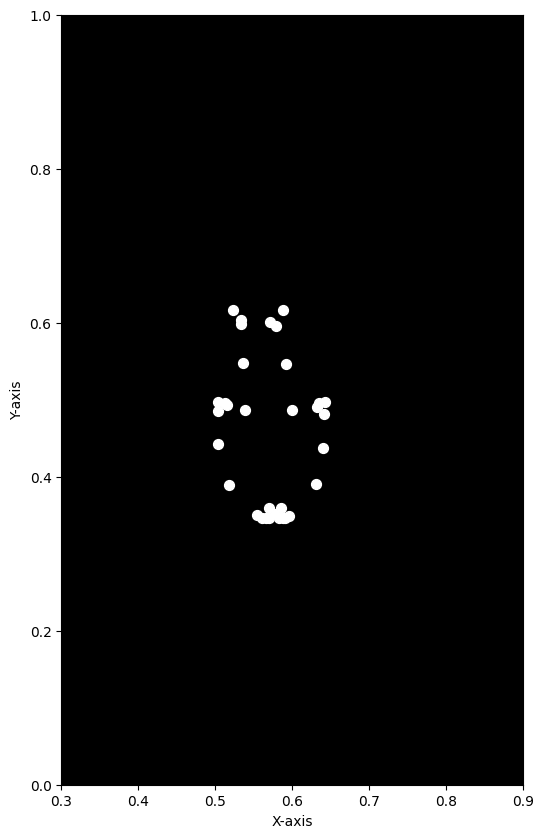

In [20]:
def visualize_c3d_2d_projection(c3d_file, plane="XZ"):
    import matplotlib.pyplot as plt
    import numpy as np

    c3d = ezc3d.c3d(c3d_file)  # Load the C3D file
    points = c3d['data']['points']  # Extract marker points (4 x markers x frames)
    num_frames = points.shape[2]  # Total number of frames

    # Set up figure for 2D visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("black")  # Set background color to black

    # Set axes labels and limits based on the selected plane
    if plane == "XY":
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.set_xlim(0.3, 0.7)  # Adjust based on X range
        ax.set_ylim(0, 0.8)  # Adjust based on Y range
    elif plane == "XZ":
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Z-axis")
        ax.set_xlim(0.3, 0.9)  # Adjust based on X range
        ax.set_ylim(-0.5, 0.5)  # Adjust based on Z range
    elif plane == "YZ":
        ax.set_xlabel("Y-axis")
        ax.set_ylabel("Z-axis")
        ax.set_xlim(0, 0.8)  # Adjust based on Y range
        ax.set_ylim(-0.5, 0.5)  # Adjust based on Z range
    else:
        raise ValueError("Invalid plane selected. Choose 'XY', 'XZ', or 'YZ'.")

    ax.set_aspect("equal", adjustable="box")  # Maintain equal scaling for axes
    ax.grid(color="white", linestyle="--", linewidth=0.5)  # Add grid lines for reference

    for frame_idx in range(num_frames):  # Loop through each frame
        ax.clear()  # Clear previous frame for animation
        ax.set_facecolor("black")  # Reset background color

        # Reset axes labels and limits for each frame
        if plane == "XY":
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Y-axis")
            ax.set_xlim(0.3, 0.9)
            ax.set_ylim(0, 1)
        elif plane == "XZ":
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Z-axis")
            ax.set_xlim(0.3, 0.7)
            ax.set_ylim(-0.5, 0.5)
        elif plane == "YZ":
            ax.set_xlabel("Y-axis")
            ax.set_ylabel("Z-axis")
            ax.set_xlim(0, 1)
            ax.set_ylim(-0.5, 0.5)

        # Plot the valid markers for the current frame
        for marker_idx in range(points.shape[1]):  # Loop through each marker
            if points[3, marker_idx, frame_idx] == 1:  # Check if marker is valid
                if plane == "XY":
                    ax.scatter(
                        points[0, marker_idx, frame_idx],  # X-coordinate
                        points[1, marker_idx, frame_idx],  # Y-coordinate
                        c="white", s=50
                    )
                elif plane == "XZ":
                    ax.scatter(
                        points[0, marker_idx, frame_idx],  # X-coordinate
                        points[2, marker_idx, frame_idx],  # Z-coordinate
                        c="white", s=50
                    )
                elif plane == "YZ":
                    ax.scatter(
                        points[1, marker_idx, frame_idx],  # Y-coordinate
                        points[2, marker_idx, frame_idx],  # Z-coordinate
                        c="white", s=50
                    )

        plt.pause(0.01)  # Pause for animation effect

    plt.show()  # Show the final plot

c3d_output_path = "/content/output.c3d"

visualize_c3d_2d_projection(c3d_output_path, 'XY')

In [7]:
import ezc3d
import numpy as np

def analyze_c3d(file_path):
    # Load the C3D file
    c3d = ezc3d.c3d(file_path)

    # General information
    print("=== C3D File Analysis ===")
    print(f"Number of frames: {c3d['data']['points'].shape[2]}")
    print(f"Number of markers: {c3d['data']['points'].shape[1]}")
    print(f"Frame rate: {c3d['parameters']['POINT']['RATE']['value'][0]} Hz")

    # Marker labels
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    print("\nMarker Labels:")
    print(", ".join(marker_labels))

    # Extracting marker positions
    print("\nMarker Data (first 5 frames):")
    for frame_idx in range(min(5, c3d['data']['points'].shape[2])):
        print(f"Frame {frame_idx + 1}:")
        for marker_idx, label in enumerate(marker_labels):
            x, y, z, validity = c3d['data']['points'][:, marker_idx, frame_idx]
            if validity == 1:  # Valid marker
                print(f"  {label}: (X={x:.3f}, Y={y:.3f}, Z={z:.3f})")
            else:
                print(f"  {label}: Invalid")

    # Analog data (if available)
    if c3d['data']['analogs'].size > 0:
        print("\nAnalog Data:")
        print(f"Number of analog channels: {c3d['data']['analogs'].shape[0]}")
        print(f"Number of analog samples per frame: {c3d['data']['analogs'].shape[1]}")
        print("First 5 analog samples (Channel 1):")
        print(c3d['data']['analogs'][0, :5])
    else:
        print("\nNo analog data available in this file.")




In [9]:
# Example usage
c3d_file_path = "output.c3d"  # Replace with your C3D file path
analyze_c3d(c3d_file_path)

OSError: The c3d file could not be opened, please verify the path

C3D file created: output_2.c3d


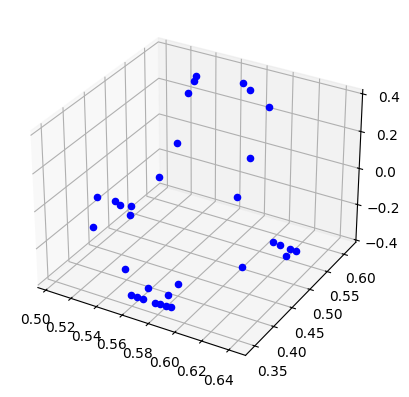

In [5]:
# Example usage
video_path = "/content/VID-20250109-WA0004.mp4"  # Replace with your video path
c3d_output_path = "output_2.c3d"

# Step 1: Extract keypoints from video
keypoints = extract_keypoints(video_path)

# Step 2: Create C3D file
create_c3d_file(keypoints, c3d_output_path, frame_rate=30)

# Step 3: Visualize in Python (optional)
visualize_c3d(c3d_output_path)

In [7]:
# Example usage
c3d_file_path = "output_2.c3d"  # Replace with your C3D file path
analyze_c3d(c3d_file_path)

=== C3D File Analysis ===
Number of frames: 323
Number of markers: 33
Frame rate: 30.0 Hz

Marker Labels:
Marker_1, Marker_2, Marker_3, Marker_4, Marker_5, Marker_6, Marker_7, Marker_8, Marker_9, Marker_10, Marker_11, Marker_12, Marker_13, Marker_14, Marker_15, Marker_16, Marker_17, Marker_18, Marker_19, Marker_20, Marker_21, Marker_22, Marker_23, Marker_24, Marker_25, Marker_26, Marker_27, Marker_28, Marker_29, Marker_30, Marker_31, Marker_32, Marker_33

Marker Data (first 5 frames):
Frame 1:
  Marker_1: (X=0.577, Y=0.352, Z=-0.360)
  Marker_2: (X=0.583, Y=0.346, Z=-0.340)
  Marker_3: (X=0.588, Y=0.346, Z=-0.340)
  Marker_4: (X=0.591, Y=0.346, Z=-0.340)
  Marker_5: (X=0.570, Y=0.346, Z=-0.342)
  Marker_6: (X=0.565, Y=0.346, Z=-0.342)
  Marker_7: (X=0.560, Y=0.346, Z=-0.342)
  Marker_8: (X=0.596, Y=0.349, Z=-0.209)
  Marker_9: (X=0.555, Y=0.350, Z=-0.223)
  Marker_10: (X=0.585, Y=0.359, Z=-0.310)
  Marker_11: (X=0.569, Y=0.360, Z=-0.314)
  Marker_12: (X=0.631, Y=0.390, Z=-0.120)
  Mark

C3D file created: output_3.c3d


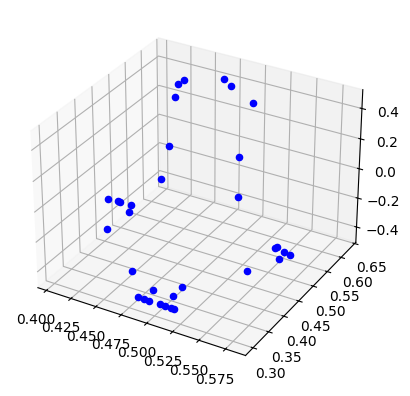

In [6]:
# Example usage
video_path = "/content/VID-20250109-WA0005.mp4"  # Replace with your video path
c3d_output_path = "output_3.c3d"

# Step 1: Extract keypoints from video
keypoints = extract_keypoints(video_path)

# Step 2: Create C3D file
create_c3d_file(keypoints, c3d_output_path, frame_rate=30)

# Step 3: Visualize in Python (optional)
visualize_c3d(c3d_output_path)

C3D file created: output_3.c3d


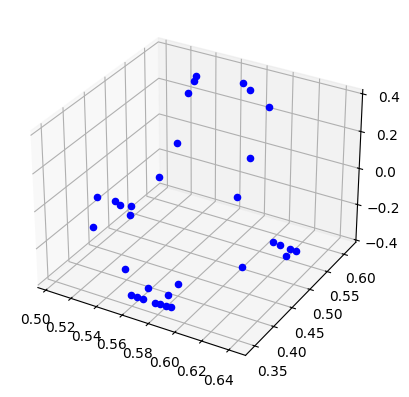

In [9]:
# Example usage
video_path = "/content/VID-20250109-WA0004.mp4"  # Replace with your video path
c3d_output_path = "output_3.c3d"

# Step 1: Extract keypoints from video
keypoints = extract_keypoints(video_path)

# Step 2: Create C3D file
create_c3d_file(keypoints, c3d_output_path, frame_rate=30)

# Step 3: Visualize in Python (optional)
visualize_c3d(c3d_output_path)

## Synchronizing IMU Data with Video Frames


1.   Closest IMU data point for each video frame
2.   Interpolation


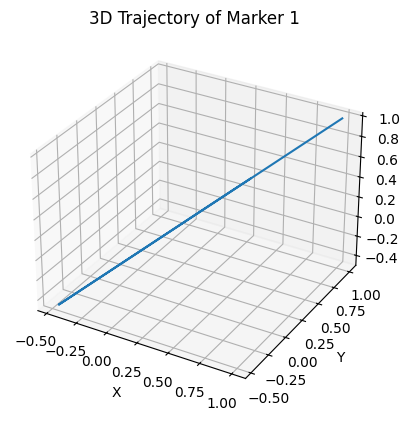

In [ ]:
import ezc3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load C3D file
c3d = ezc3d.c3d('output.c3d')

# Extract 3D marker positions (shape: [n_frames, n_markers, 3])
markers_3d = c3d['data']['points']

# Extract analog data (acceleration, force) if available (shape: [n_frames, n_channels])
analog_data = c3d['data']['analogs']

# Visualize 3D marker data (e.g., 1st marker)
frames = np.arange(markers_3d.shape[0])
marker_1 = markers_3d[:, 0, :]  # 1st marker (x, y, z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(marker_1[:, 0], marker_1[:, 1], marker_1[:, 2])
ax.set_title("3D Trajectory of Marker 1")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# Visualize analog data (e.g., acceleration of a sensor)
if analog_data.shape[1] > 0:
    acceleration = analog_data[:, 0]  # Assuming first analog channel is acceleration
    plt.plot(frames, acceleration)
    plt.title("Acceleration Over Time")
    plt.xlabel("Frame")
    plt.ylabel("Acceleration (m/s^2)")
    plt.show()


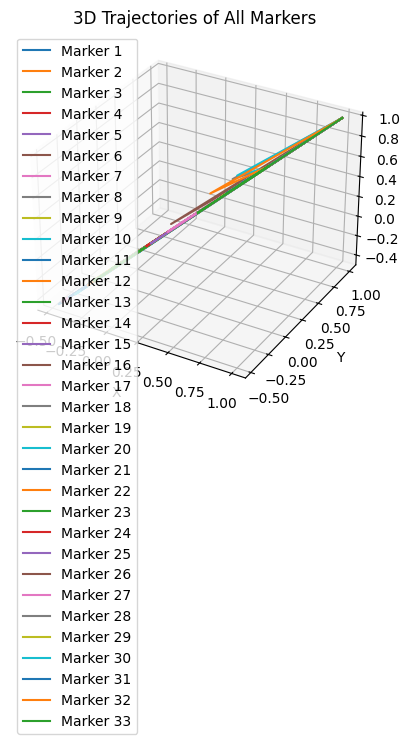

In [ ]:
import ezc3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the C3D file
c3d = ezc3d.c3d('output.c3d')

# Extract 3D marker positions (shape: [n_frames, n_markers, 3])
markers_3d = c3d['data']['points']

# Create a 3D plot for the markers
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop through each marker (loop over marker index)
for marker_idx in range(markers_3d.shape[1]):
    marker = markers_3d[:, marker_idx, :]  # 3D coordinates of each marker (x, y, z)
    ax.plot(marker[:, 0], marker[:, 1], marker[:, 2], label=f"Marker {marker_idx + 1}")

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectories of All Markers')

# Show legend
ax.legend()

# Display the 3D plot
plt.show()
